In [1]:
# Install required libraries
!pip install yfinance timesfm

  Using cached nvidia_nvjitlink_cu12-12.6.20-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 

In [1]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=0dcb0e84741b1e83e2a6df4f48a3c78f3cda49765683f8f8b78e989fe303bc0c
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import os
import time
import timesfm
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
# Load TimesFM model
timesfm_backend = "gpu"  # or 'cpu'
from jax._src import config
config.update("jax_platforms", {"cpu": "cpu", "gpu": "cuda", "tpu": ""}[timesfm_backend])

In [4]:
import yfinance as yf
import ta
import pandas as pd

# تنظیمات
ticker = 'AAPL'  # Example: Apple Inc.
start_date = "2022-10-12"
end_date = "2024-01-01"
analysis_start_date = "2023-01-03"  # تاریخ شروع مورد نظر

# دانلود داده‌های سهام از Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)
data = data.resample('1D').ffill()


# محاسبه میانگین‌های متحرک و اندیکاتورهای تکنیکال
data['moving_avg_10'] = data['Close'].rolling(window=10).mean()
data['moving_avg_50'] = data['Close'].rolling(window=50).mean()
data['rsi'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
data['ema'] = ta.trend.EMAIndicator(data['Close'], window=10).ema_indicator()

# حذف سطرهایی که دارای مقادیر NaN هستند (به دلیل محاسبات میانگین‌های متحرک)


# فیلتر کردن داده‌ها از تاریخ شروع مورد نظر
data = data[data.index >= analysis_start_date]

# تنظیم DataFrame نهایی
df = data[['Close', 'Volume', 'moving_avg_10', 'moving_avg_50', 'rsi', 'ema']].reset_index()
df.columns = ['date', 'close', 'volume', 'moving_avg_10', 'moving_avg_50', 'rsi', 'ema']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# نمایش داده‌ها
df


[*********************100%%**********************]  1 of 1 completed


,close,volume,moving_avg_10,moving_avg_50,rsi,ema
date,,,,,,
2023-01-03,125.070000,112117500,129.418997,140.726199,28.126213,129.554483
2023-01-04,126.360001,89113600,128.868997,140.252599,32.455056,128.973668
2023-01-05,125.019997,80962700,128.184997,139.777199,30.406409,128.254819
2023-01-06,129.619995,87754700,128.143996,139.355199,43.573855,128.503033
2023-01-07,129.619995,87754700,128.501996,138.921799,43.573855,128.706117
...,...,...,...,...,...,...
2023-12-25,193.600006,37122800,195.188004,191.248201,50.022824,194.581887
2023-12-26,193.050003,28919300,194.736003,191.524601,47.619812,194.303362
2023-12-27,193.149994,48087700,194.294002,191.751201,48.107867,194.093659


In [5]:


def get_batched_data_fn(batch_size: int = 32, context_len: int = 32, horizon_len: int = 1):
    examples = defaultdict(list)
    num_examples = 0
    for start in range(0, len(df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        context_end = start + context_len
        examples["inputs"].append(df["close"][start:context_end].tolist())
        examples["volume"].append(df["volume"][start:context_end].tolist() + [df["volume"].iloc[context_end - 1]])
        examples["moving_avg_10"].append(df["moving_avg_10"][start:context_end].tolist() + [df["moving_avg_10"].iloc[context_end - 1]])
        examples["moving_avg_50"].append(df["moving_avg_50"][start:context_end].tolist() + [df["moving_avg_50"].iloc[context_end - 1]])
        examples["rsi"].append(df["rsi"][start:context_end].tolist() + [df["rsi"].iloc[context_end - 1]])
        examples["ema"].append(df["ema"][start:context_end].tolist() + [df["ema"].iloc[context_end - 1]])
        examples["outputs"].append(df["close"][context_end:context_end + horizon_len].tolist())
        examples["dates"].append(df.index[start:context_end + horizon_len].tolist())  # Add dates to examples

    def data_fn():
        for i in range(1 + (num_examples - 1) // batch_size):
            yield {k: v[(i * batch_size): ((i + 1) * batch_size)] for k, v in examples.items()}

    return data_fn

In [6]:


# Define metrics
def mse(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.square(y_pred - y_true), axis=1, keepdims=True)

def mae(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.abs(y_pred - y_true), axis=1, keepdims=True)

In [7]:
import timesfm

context_len = 64
batch_size = 1  # ثابت نگه‌داشتن batch size
horizon_len = 1  # ثابت نگه‌داشتن horizon length



In [8]:

    model = timesfm.TimesFm(
        context_len=context_len,
        horizon_len=horizon_len,
        input_patch_len=32,
        output_patch_len=128,
        num_layers=20,
        model_dims=1280,
        backend="gpu",
    )
    model.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 3.73 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.40 seconds.
Jitting decoding.
Jitted decoding in 24.13 seconds.


In [18]:
import os
import time
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import timesfm
import ta
from itertools import combinations
import gc
import json



features = ["volume", "moving_avg_10", "moving_avg_50", "rsi", "ema"]
feature_combinations = []
for r in range(1, len(features) + 1):
    feature_combinations.extend(combinations(features, r))
results_by_cov = []

for combo in feature_combinations:
    print(f"Processing combo: {combo}")
    input_data = get_batched_data_fn(batch_size=batch_size, context_len=context_len, horizon_len=1)
    metrics = defaultdict(list)


    # Process in smaller sub-batches
    for i, example in enumerate(input_data()):
        dynamic_numerical_covariates = {feature: example[feature] for feature in combo}
        raw_forecast, _ = model.forecast(
                            inputs=example["inputs"], freq=[0] * len(example["inputs"])
                        )
        cov_forecast, ols_forecast = model.forecast_with_covariates(
           inputs=example["inputs"],
           dynamic_numerical_covariates=dynamic_numerical_covariates,
           dynamic_categorical_covariates={},
           static_numerical_covariates={},
           static_categorical_covariates={},
           freq=[0] * len(example["inputs"]),
           normalize_xreg_target_per_input=True,
           xreg_mode="xreg + timesfm",)


        for j in range(len(example["inputs"])):
            result = {
                'input_index': j,
                'train_start_date': str(example["dates"][j][0]),
                'train_end_date': str(example["dates"][j][-2]),
                'predict_date': str(example["dates"][j][-1]),
                'raw_forecast': raw_forecast[j][0],
                'y_predict' : cov_forecast[j][0],
                'y_actual': example["outputs"][j][0],
                'batch_size': batch_size,
                'context_len': context_len,
                "timesfm + xreg":"timesfm + xreg",
                'combo' : combo,

            }
            results_by_cov.append(result)


Processing combo: ('volume',)
Processing combo: ('moving_avg_10',)
Processing combo: ('moving_avg_50',)
Processing combo: ('rsi',)
Processing combo: ('ema',)
Processing combo: ('volume', 'moving_avg_10')
Processing combo: ('volume', 'moving_avg_50')
Processing combo: ('volume', 'rsi')
Processing combo: ('volume', 'ema')
Processing combo: ('moving_avg_10', 'moving_avg_50')
Processing combo: ('moving_avg_10', 'rsi')
Processing combo: ('moving_avg_10', 'ema')
Processing combo: ('moving_avg_50', 'rsi')
Processing combo: ('moving_avg_50', 'ema')
Processing combo: ('rsi', 'ema')
Processing combo: ('volume', 'moving_avg_10', 'moving_avg_50')
Processing combo: ('volume', 'moving_avg_10', 'rsi')
Processing combo: ('volume', 'moving_avg_10', 'ema')
Processing combo: ('volume', 'moving_avg_50', 'rsi')
Processing combo: ('volume', 'moving_avg_50', 'ema')
Processing combo: ('volume', 'rsi', 'ema')
Processing combo: ('moving_avg_10', 'moving_avg_50', 'rsi')
Processing combo: ('moving_avg_10', 'movin

In [47]:
 results_df = pd.DataFrame(results_by_cov)
 results_df

,input_index,train_start_date,train_end_date,predict_date,raw_forecast,y_predict,y_actual,batch_size,context_len,timesfm + xreg,combo
0,0,2023-01-03 00:00:00,2023-03-07 00:00:00,2023-03-08 00:00:00,152.566696,152.568146,152.869995,1,64,timesfm + xreg,"(volume,)"
1,0,2023-01-04 00:00:00,2023-03-08 00:00:00,2023-03-09 00:00:00,153.315903,153.289413,150.589996,1,64,timesfm + xreg,"(volume,)"
2,0,2023-01-05 00:00:00,2023-03-09 00:00:00,2023-03-10 00:00:00,151.186523,151.244919,148.500000,1,64,timesfm + xreg,"(volume,)"
3,0,2023-01-06 00:00:00,2023-03-10 00:00:00,2023-03-11 00:00:00,149.242218,149.539703,148.500000,1,64,timesfm + xreg,"(volume,)"
4,0,2023-01-07 00:00:00,2023-03-11 00:00:00,2023-03-12 00:00:00,148.789383,149.141953,148.500000,1,64,timesfm + xreg,"(volume,)"
...,...,...,...,...,...,...,...,...,...,...,...
9171,0,2023-10-21 00:00:00,2023-12-23 00:00:00,2023-12-24 00:00:00,193.560013,193.346329,193.600006,1,64,timesfm + xreg,"(volume, moving_avg_10, moving_avg_50, rsi, ema)"
9172,0,2023-10-22 00:00:00,2023-12-24 00:00:00,2023-12-25 00:00:00,193.652313,193.734055,193.600006,1,64,timesfm + xreg,"(volume, moving_avg_10, moving_avg_50, rsi, ema)"
9173,0,2023-10-23 00:00:00,2023-12-25 00:00:00,2023-12-26 00:00:00,193.921982,193.817093,193.050003,1,64,timesfm + xreg,"(volume, moving_avg_10, moving_avg_50, rsi, ema)"
9174,0,2023-10-24 00:00:00,2023-12-26 00:00:00,2023-12-27 00:00:00,193.380096,193.204407,193.149994,1,64,timesfm + xreg,"(volume, moving_avg_10, moving_avg_50, rsi, ema)"


In [49]:
# تبدیل نتایج به DataFrame
results_df = pd.DataFrame(results_df)

# ذخیره DataFrame به صورت pickle
results_df.to_pickle('combo _reg_timesfm.pkl')

print("DataFrame successfully saved as pickle file.")


DataFrame successfully saved as pickle file.


In [50]:
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score

# توابع محاسبه متریک‌ها
def calculate_mse(context_results_df_actual, context_results_df_predicted):
    return mean_squared_error(context_results_df_actual, context_results_df_predicted)

def calculate_accuracy(context_results_df_actual, context_results_df_predicted):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(context_results_df_actual)):
        actual_today = context_results_df_actual.iloc[i]
        predicted_today = context_results_df_predicted.iloc[i]
        actual_yesterday = context_results_df_actual.iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1

    return correct_predictions / total_predictions if total_predictions > 0 else 0

def calculate_profit(context_results_df_actual, context_results_df_predicted, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(context_results_df_actual)):
        today_price = context_results_df_actual.iloc[i]
        yesterday_price = context_results_df_actual.iloc[i - 1]
        predicted_today_price = context_results_df_predicted.iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df_actual.iloc[-1]

    return capital - initial_capital

def calculate_actual_direction_accuracy(context_results_df_actual, context_results_df_predicted):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df_actual)):
        real_directions.append(get_direction(context_results_df_actual.iloc[i - 1], context_results_df_actual.iloc[i]))
        predicted_directions.append(get_direction(context_results_df_actual.iloc[i - 1], context_results_df_predicted.iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_accuracy(context_results_df_actual, context_results_df_predicted):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df_actual)):
        real_directions.append(get_direction(context_results_df_actual.iloc[i - 1], context_results_df_actual.iloc[i]))
        predicted_directions.append(get_direction(context_results_df_predicted.iloc[i - 1], context_results_df_predicted.iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_profit(context_results_df_actual, context_results_df_predicted, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(context_results_df_actual)):
        yesterday_price = context_results_df_actual.iloc[i - 1]
        yesterday_predicted_today_price = context_results_df_predicted.iloc[i - 1]
        predicted_today_price = context_results_df_predicted.iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df_actual.iloc[-1]

    return capital - initial_capital

def calculate_results_for_combo(combo, context_results_df_actual, context_results_df_predicted):
    # محاسبه مقادیر متریک‌ها
    mse_value = calculate_mse(context_results_df_actual, context_results_df_predicted)
    accuracy_value = calculate_accuracy(context_results_df_actual, context_results_df_predicted)
    profit = calculate_profit(context_results_df_actual, context_results_df_predicted)
    direction_accuracy = calculate_direction_accuracy(context_results_df_actual, context_results_df_predicted)
    actual_direction_accuracy = calculate_actual_direction_accuracy(context_results_df_actual, context_results_df_predicted)
    direction_profit = calculate_direction_profit(context_results_df_actual, context_results_df_predicted)

    # ساخت دیکشنری از نتایج محاسبه شده
    result = {
        'combo': combo,
        'mse': mse_value,
        'accuracy': accuracy_value,
        'direction_accuracy': direction_accuracy,
        'actual_direction_accuracy': actual_direction_accuracy,
        'direction_profit': direction_profit,
        'profit': profit
    }

    return pd.DataFrame([result])

# حالا نتایج را برای هر combo حساب می‌کنیم
final_results = []

for combo in results_df['combo'].unique():
    combo_data_actual = results_df[results_df['combo'] == combo]['y_actual']
    combo_data_predicted = results_df[results_df['combo'] == combo]['y_predict']

    combo_results_df = calculate_results_for_combo(combo, combo_data_actual, combo_data_predicted)
    final_results.append(combo_results_df)

# ترکیب تمام نتایج در یک DataFrame
final_results_df = pd.concat(final_results).reset_index(drop=True)

# نمایش نتایج نهایی
print(final_results_df)


                                               combo       mse  accuracy  \
0                                          (volume,)  3.853742  0.338983   
1                                   (moving_avg_10,)  3.585444  0.335593   
2                                   (moving_avg_50,)  3.831339  0.338983   
3                                             (rsi,)  3.592674  0.301695   
4                                             (ema,)  3.555477  0.359322   
5                            (volume, moving_avg_10)  3.547727  0.335593   
6                            (volume, moving_avg_50)  3.999197  0.315254   
7                                      (volume, rsi)  3.773099  0.335593   
8                                      (volume, ema)  3.558615  0.325424   
9                     (moving_avg_10, moving_avg_50)  3.672011  0.311864   
10                              (moving_avg_10, rsi)  3.153299  0.362712   
11                              (moving_avg_10, ema)  3.460788  0.301695   
12          

In [51]:

# پیدا کردن بهترین combo‌ها برای هر معیار
best_mse_combo = final_results_df.loc[final_results_df['mse'].idxmin()]
best_accuracy_combo = final_results_df.loc[final_results_df['accuracy'].idxmax()]
best_profit_combo = final_results_df.loc[final_results_df['profit'].idxmax()]
best_direction_accuracy_combo = final_results_df.loc[final_results_df['direction_accuracy'].idxmax()]
best_actual_direction_accuracy_combo = final_results_df.loc[final_results_df['actual_direction_accuracy'].idxmax()]
best_direction_profit_combo = final_results_df.loc[final_results_df['direction_profit'].idxmax()]

# نمایش بهترین ترکیب‌ها برای هر معیار
print("Best Combinations by Metric:")
print(f"Best MSE Combo: {best_mse_combo['combo']} with MSE: {best_mse_combo['mse']}")
print(f"Best Accuracy Combo: {best_accuracy_combo['combo']} with Accuracy: {best_accuracy_combo['accuracy']}")
print(f"Best Profit Combo: {best_profit_combo['combo']} with Profit: {best_profit_combo['profit']}")
print(f"Best Direction Accuracy Combo: {best_direction_accuracy_combo['combo']} with Direction Accuracy: {best_direction_accuracy_combo['direction_accuracy']}")
print(f"Best Actual Direction Accuracy Combo: {best_actual_direction_accuracy_combo['combo']} with Actual Direction Accuracy: {best_actual_direction_accuracy_combo['actual_direction_accuracy']}")
print(f"Best Direction Profit Combo: {best_direction_profit_combo['combo']} with Direction Profit: {best_direction_profit_combo['direction_profit']}")

Best Combinations by Metric:
Best MSE Combo: ('moving_avg_10', 'rsi') with MSE: 3.1532986450120744
Best Accuracy Combo: ('moving_avg_10', 'moving_avg_50', 'rsi') with Accuracy: 0.3694915254237288
Best Profit Combo: ('moving_avg_10', 'rsi') with Profit: 25.967491055145572
Best Direction Accuracy Combo: ('moving_avg_10', 'ema') with Direction Accuracy: 0.5152542372881356
Best Actual Direction Accuracy Combo: ('moving_avg_10', 'rsi') with Actual Direction Accuracy: 0.6033898305084746
Best Direction Profit Combo: ('volume', 'rsi') with Direction Profit: 25.841844595203938


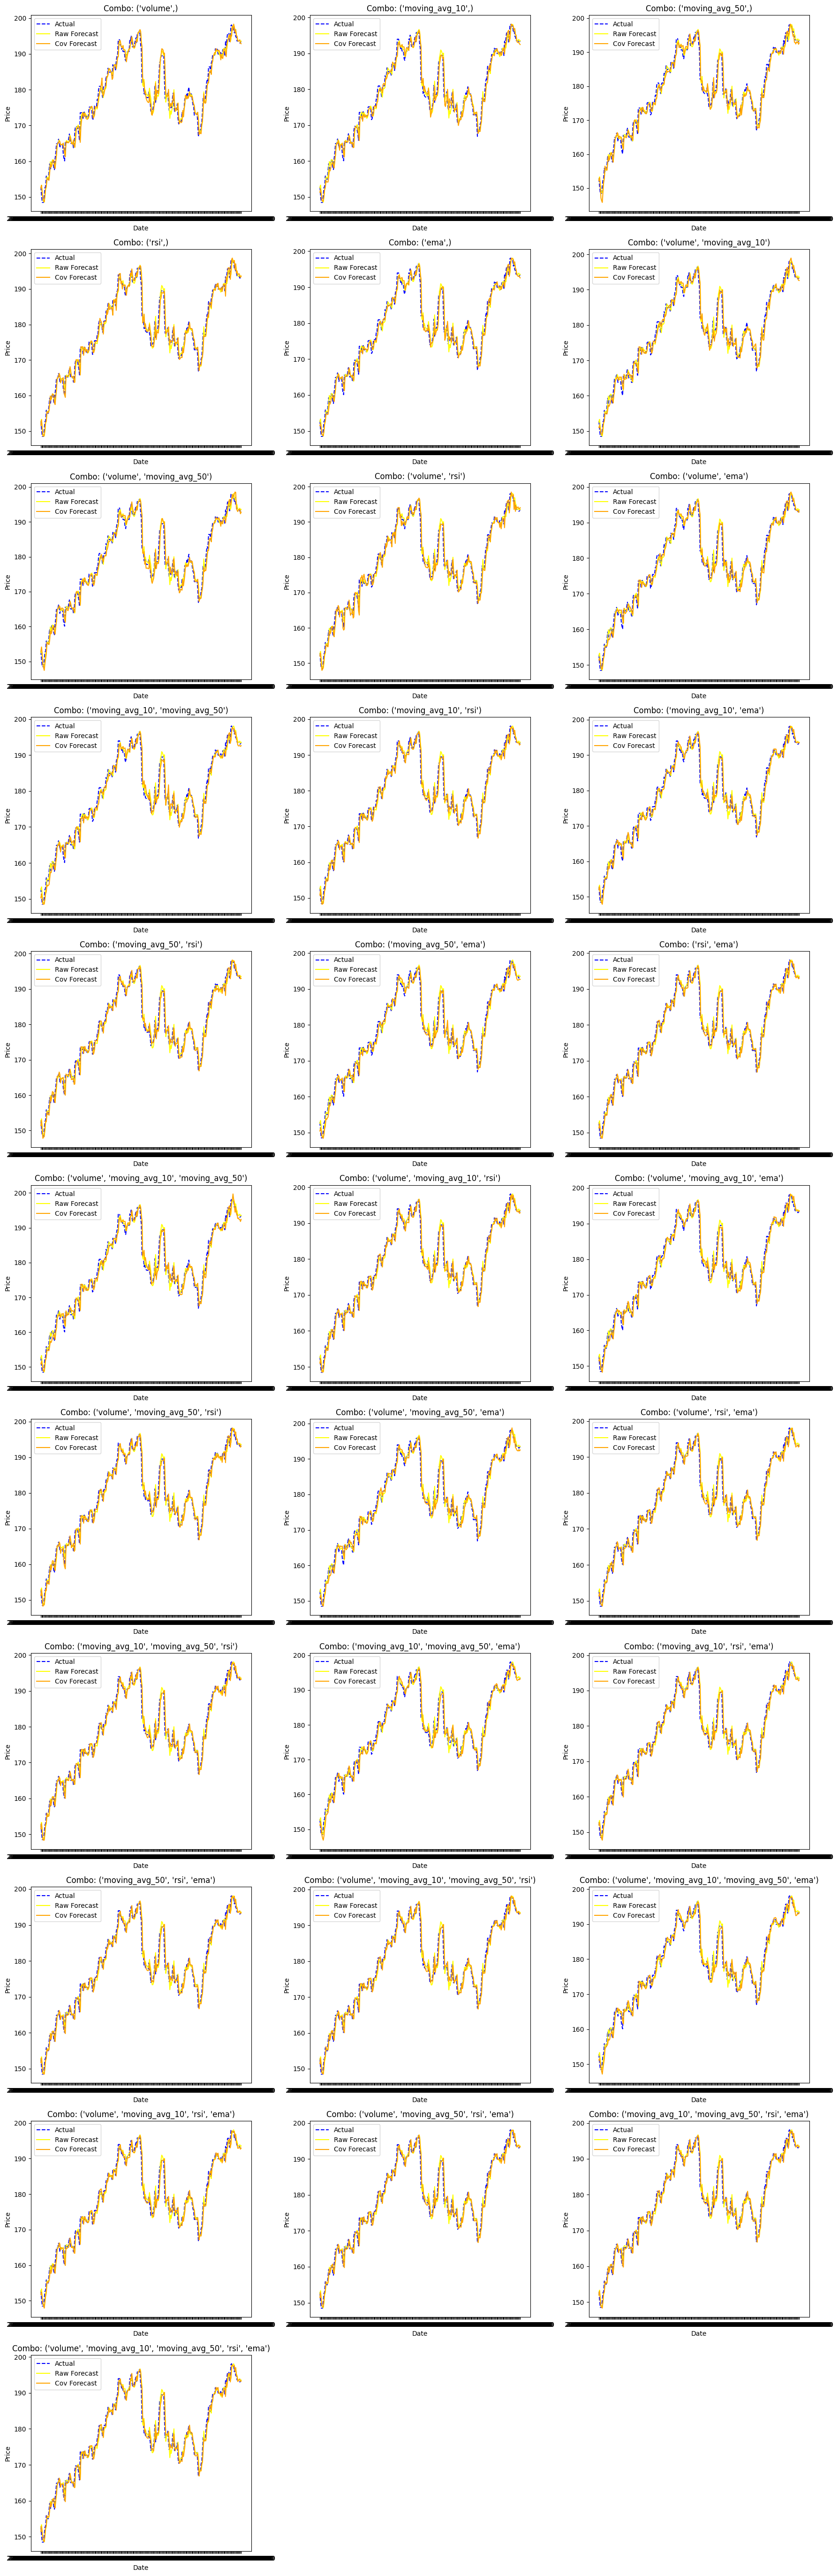

In [53]:
# تبدیل نتایج نهایی به یک DataFrame


# تعداد سطرها و ستون‌ها برای نمودارها
num_columns = 3
num_combos = len(feature_combinations)
num_rows = math.ceil(num_combos / num_columns)

# ایجاد نمودارهای چندگانه
fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, 5 * num_rows))

# تبدیل axes به یک لیست مسطح برای دسترسی آسان
axes = axes.flatten()

for idx, combo in enumerate(feature_combinations):
    combo_results = results_df[results_df['combo'] == combo]


    axes[idx].plot(combo_results['predict_date'], combo_results['y_actual'], label='Actual', color='blue', linestyle='--')
    axes[idx].plot(combo_results['predict_date'], combo_results['raw_forecast'], label='Raw Forecast', color='yellow')
    axes[idx].plot(combo_results['predict_date'], combo_results['y_predict'], label='Cov Forecast', color='orange')

    axes[idx].set_title(f'Combo: {combo}')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Price')
    axes[idx].legend()

# حذف هر subplot خالی
for ax in axes[num_combos:]:
    fig.delaxes(ax)

# تنظیم فاصله بین نمودارها
plt.tight_layout()
plt.show()


In [54]:
# محاسبه‌ی متریک‌ها برای پیش‌بینی خام (Raw Forecast)
results_df=results_df[results_df['combo'] == combo]
y_actual = results_df['y_actual'].values
raw_forecast = results_df['raw_forecast'].values


# محاسبه متریک‌ها با استفاده از توابع از پیش تعریف شده
mse_value = calculate_mse(pd.Series(y_actual), pd.Series(raw_forecast))
accuracy_value = calculate_accuracy(pd.Series(y_actual), pd.Series(raw_forecast))
profit_value = calculate_profit(pd.Series(y_actual), pd.Series(raw_forecast))
direction_accuracy_value = calculate_direction_accuracy(pd.Series(y_actual), pd.Series(raw_forecast))
actual_direction_accuracy_value = calculate_actual_direction_accuracy(pd.Series(y_actual), pd.Series(raw_forecast))
direction_profit_value = calculate_direction_profit(pd.Series(y_actual), pd.Series(raw_forecast))

# نمایش نتایج محاسباتی
print(f"MSE: {mse_value}")
print(f"Accuracy: {accuracy_value}")
print(f"Profit: {profit_value}")
print(f"Direction Accuracy: {direction_accuracy_value}")
print(f"Actual Direction Accuracy: {actual_direction_accuracy_value}")
print(f"Direction Profit: {direction_profit_value}")


MSE: 3.659855458404038
Accuracy: 0.36610169491525424
Profit: 12.19780804281011
Direction Accuracy: 0.488135593220339
Actual Direction Accuracy: 0.5050847457627119
Direction Profit: 14.153185864073976
